In [1]:
# System
from typing import Dict, Tuple, Sequence
import dill as pickle
pickle.settings['recurse'] = True
import logging
import time
import gc

# Essentials DS
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import scipy

# Pipelining
from sklearn.base import TransformerMixin

# Model
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# Evaluation Tools
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,\
                            precision_recall_fscore_support, classification_report, confusion_matrix,\
                            roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve


# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Logger for saving logs in external log file
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='./model_training.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [3]:
# Constants for Recreatability
RANDOM_STATE = 42

# Preliminary Data Exploration

This sections loads data and allows quick inspection on basic data properties.

In [4]:
df = pd.read_csv("./data/data.csv")

In [5]:
df.head(n=3)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_binned
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,<=50k
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,<=50k
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,<=50k


In [6]:
# Convert seemingly integer features to categorical as they are meant to be
int_to_str_cols = ['detailed_industry_recode', 
                   'detailed_occupation_recode',
                   'own_business_or_self_employed',
                   'veterans_benefits']

df[int_to_str_cols] = df[int_to_str_cols].astype(str)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299285 entries, 0 to 299284
Data columns (total 41 columns):
age                                           299285 non-null int64
class_of_worker                               299285 non-null object
detailed_industry_recode                      299285 non-null object
detailed_occupation_recode                    299285 non-null object
education                                     299285 non-null object
wage_per_hour                                 299285 non-null int64
enroll_in_edu_inst_last_wk                    299285 non-null object
marital_stat                                  299285 non-null object
major_industry_code                           299285 non-null object
major_occupation_code                         299285 non-null object
race                                          299285 non-null object
hispanic_origin                               298006 non-null object
sex                                           299285 non-null o

## Distribution Check

Income with more than 50k is the minority cases, currently stands at around 6% of entire data population.

In [8]:
df['income_binned'].value_counts()

<=50k    280717
>50k      18568
Name: income_binned, dtype: int64

In [9]:
df['income_binned'].value_counts(1)

<=50k    0.937959
>50k     0.062041
Name: income_binned, dtype: float64

### Conversion of truth label

Changing labels from string to boolean for training purpose.

In [10]:
# Convert the truth label from string to boolean
df['income_binned'] = df['income_binned'].apply(lambda x: True if x == '>50k' else False)

# Null Value Fix

Normally null value can be replaced by searching for rows with high amount of
similar features. This process however can be expensive.

Null values can also be replaced with the majority class if the distribution within
the column is skewed to majority class and null values are not common
(as the replacement would not drastically change the distribution within the feature).

Fastest way to quickly patch this around is simply assigning a new class for null values.
Due to the time constraint and for convenience, this method is used.

In [11]:
# Catch columns with null values
for col in df.columns.values:
    if df[col].isnull().values.any():
        # Get column type to assign null fix value accordingly
        col_type = df[col].dtype
        print(f"Null values exist in {col} of type {col_type}.")
        
        if col_type == object:
            df[col] = df[col].fillna('-1')
        elif col_type == int:
            df[col] = df[col].fillna(-1)

Null values exist in hispanic_origin of type object.


# Train Test Split

Before performing any exploratory data analysis (EDA), it is important to first split 
the given dataset into train and test. 

This is to prevent any form of analysis or decision made on the basis of ENTIRE 
dataset being applied to the test dataset. That may potentially cause the illusion 
that model trained has been doing well when it might have been contributed by the 
previous act.

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [13]:
df_train['income_binned'].value_counts(1)

False    0.937618
True     0.062382
Name: income_binned, dtype: float64

In [14]:
df_test['income_binned'].value_counts(1)

False    0.939322
True     0.060678
Name: income_binned, dtype: float64

In [15]:
df_train.head(n=3)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_binned
242584,35,Private,32,37,11th grade,0,Not in universe,Separated,Wholesale trade,Machine operators assmblrs & inspctrs,White,All other,Male,Not in universe,Other job loser,Unemployed full-time,0,0,0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,?,?,?,Not in universe under 1 year old,?,3,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,False
176350,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,False
5241,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Grandchild <18 never marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Neither parent present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,False


# Input and Label Split

Prior to EDA, split both train and test dataframes into respective X and Y to prevent
label accidentally introduced into the EDA process.

In [16]:
train_X, train_y = df_train.drop(columns=['income_binned']), df_train['income_binned']

test_X, test_y = df_test.drop(columns=['income_binned']), df_test['income_binned']

# Exploratory Data Analysis

Considering we have only two types of data,

1) int64

2) object

we will first check the integer features then the categorical features.

## 1. Numerical Features

In [17]:
# Select only features of integer type
train_X_int = train_X.select_dtypes(include=['int64'])

In [18]:
train_X_int.head(n=3)

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,year
242584,35,0,0,0,0,3,30,95
176350,9,0,0,0,0,0,0,94
5241,9,0,0,0,0,0,0,95


### Pearson Correlation

The corr function makes use of Pearson correlation that measures the LINEAR correlation
between features. In other words, it only measures relation between TWO features at a 
time. 

While this might not be ideal for multivariate settings, it is good enough for
us to perform some feature selection in the beginning stage.

Going through every integer feature, we want to:
- retain feature of less correlation with other features (indicating independent 
  information)
- filter out features of highly correlated, reduce the selection size.

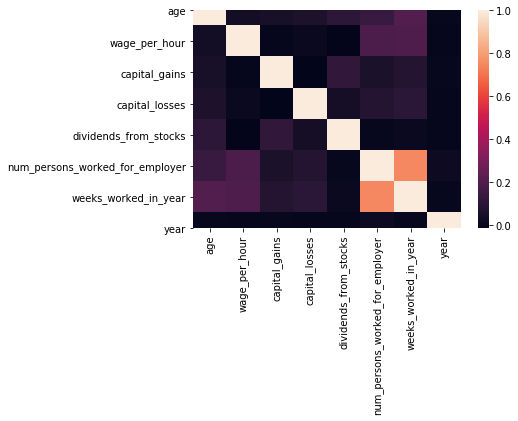

In [19]:
int_cols_corr = train_X_int.corr()
sns.heatmap(int_cols_corr,
            xticklabels=int_cols_corr.columns.values,
            yticklabels=int_cols_corr.columns.values)

A clearer view with the magnitude of correlation plotted.

In [20]:
int_cols_corr.style.background_gradient(cmap='coolwarm')

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,year
age,1,0.034898,0.0537465,0.0631326,0.106026,0.13935,0.204386,0.00386018
wage_per_hour,0.034898,1,0.00106598,0.0129524,-0.00798685,0.191444,0.195469,0.00109698
capital_gains,0.0537465,0.00106598,1,-0.0127908,0.121609,0.0592234,0.0843301,0.00552331
capital_losses,0.0631326,0.0129524,-0.0127908,1,0.0451151,0.083073,0.100627,0.000331219
dividends_from_stocks,0.106026,-0.00798685,0.121609,0.0451151,1,0.00646977,0.0143947,0.00252456
num_persons_worked_for_employer,0.13935,0.191444,0.0592234,0.083073,0.00646977,1,0.747608,0.0200124
weeks_worked_in_year,0.204386,0.195469,0.0843301,0.100627,0.0143947,0.747608,1,0.00688035
year,0.00386018,0.00109698,0.00552331,0.000331219,0.00252456,0.0200124,0.00688035,1


Apart from 'weeks_worked_in_year' has high correlation with 'num_persons_worked_for_employer',
the remaining features are quite independent of each other as shown by the correlation
score.

There are not a lot of numerical features to begin with so we can store both features
now unless dimension of input feature matrix gets too big.

In [21]:
numerical_feats = train_X_int.columns.to_list()

## 2. Categorical Feature

### Categorical Variable Investigation

We plot out the distribution of classes within each categorical variable.

In [22]:
# Select columns of object type
train_X_obj = train_X.select_dtypes(include=['object'])

In [23]:
def categorical_bar_plot(x: pd.Series, title: str) -> None:
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x.index, x.values)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=90)
    plt.title(title)
    plt.ylabel('Frequency Counts')
    plt.xlabel(title)
    plt.show()

-------class_of_worker----------
Not in universe                   0.502239
Private                           0.360939
Self-employed-not incorporated    0.042739
Local government                  0.038496
State government                  0.021489
Self-employed-incorporated        0.016402
Federal government                0.014781
Never worked                      0.002088
Without pay                       0.000827
Name: class_of_worker, dtype: float64


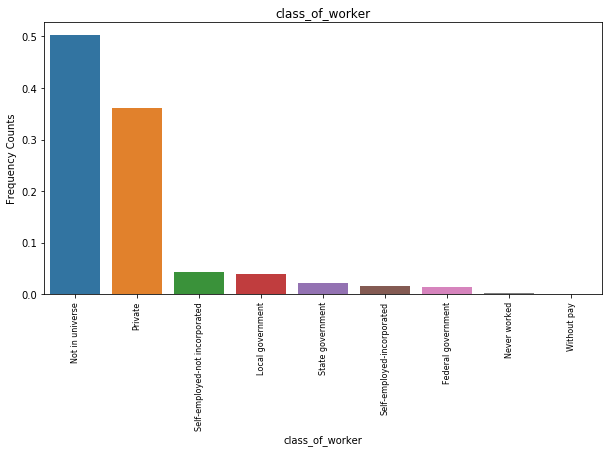

---------------------------
-------detailed_industry_recode----------
0     0.504327
33    0.085809
43    0.041741
4     0.030368
42    0.023356
45    0.022437
29    0.021618
37    0.020603
41    0.019551
32    0.017968
35    0.017057
39    0.014635
34    0.013566
44    0.012689
2     0.010993
11    0.008946
50    0.008345
38    0.008261
40    0.008253
47    0.008107
24    0.007627
19    0.006975
12    0.006774
30    0.005835
31    0.005793
25    0.005283
9     0.005066
36    0.004807
22    0.004665
13    0.004544
1     0.004005
48    0.003112
27    0.003112
49    0.003024
3     0.002936
5     0.002790
21    0.002744
8     0.002690
23    0.002690
16    0.002656
6     0.002569
15    0.002331
18    0.002247
7     0.002201
14    0.001499
46    0.000986
17    0.000773
28    0.000685
26    0.000601
51    0.000171
20    0.000159
10    0.000021
Name: detailed_industry_recode, dtype: float64


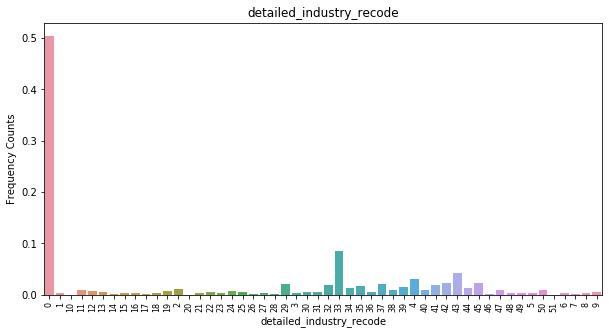

---------------------------
-------detailed_occupation_recode----------
0     0.504327
2     0.044017
26    0.038767
19    0.027486
29    0.025928
36    0.020908
34    0.020244
10    0.018081
16    0.017329
23    0.016861
12    0.016736
33    0.016711
3     0.016130
35    0.015938
38    0.015382
31    0.013457
32    0.012116
37    0.011127
8     0.010504
30    0.009535
42    0.009318
17    0.009218
24    0.009205
28    0.008073
41    0.008002
44    0.007944
4     0.006946
43    0.006879
13    0.006361
18    0.005588
39    0.005045
14    0.004527
5     0.004385
15    0.004160
27    0.004089
25    0.004001
7     0.003717
9     0.003700
11    0.003183
40    0.003174
1     0.002648
21    0.002640
6     0.002155
22    0.002080
45    0.000865
20    0.000338
46    0.000171
Name: detailed_occupation_recode, dtype: float64


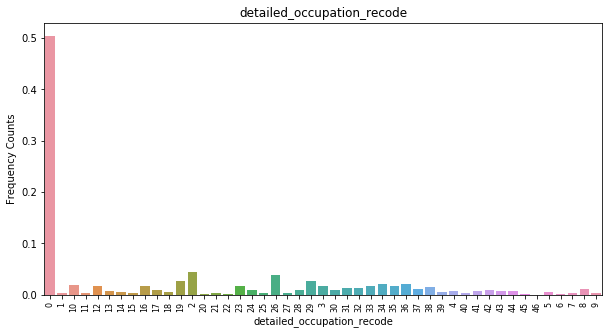

---------------------------
-------education----------
High school graduate                      0.241872
Children                                  0.237391
Some college but no degree                0.139679
Bachelors degree(BA AB BS)                0.099195
7th and 8th grade                         0.040513
10th grade                                0.037761
11th grade                                0.034503
Masters degree(MA MS MEng MEd MSW MBA)    0.032974
9th grade                                 0.031375
Associates degree-occup /vocational       0.026968
Associates degree-academic program        0.021660
5th or 6th grade                          0.016815
12th grade no diploma                     0.010780
1st 2nd 3rd or 4th grade                  0.009143
Prof school degree (MD DDS DVM LLB JD)    0.008850
Doctorate degree(PhD EdD)                 0.006369
Less than 1st grade                       0.004152
Name: education, dtype: float64


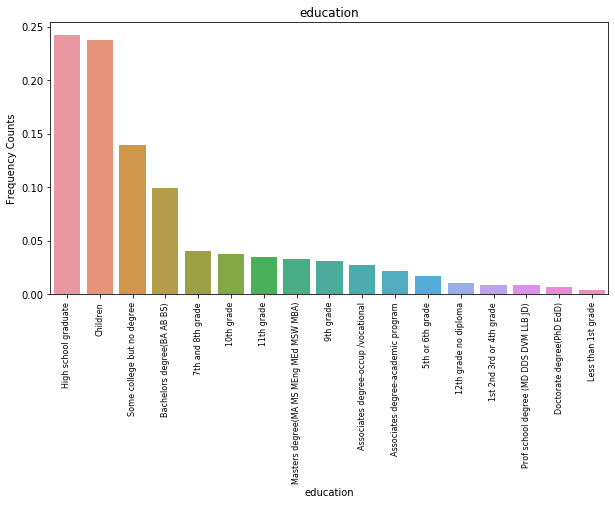

---------------------------
-------enroll_in_edu_inst_last_wk----------
Not in universe          0.937150
High school              0.034503
College or university    0.028347
Name: enroll_in_edu_inst_last_wk, dtype: float64


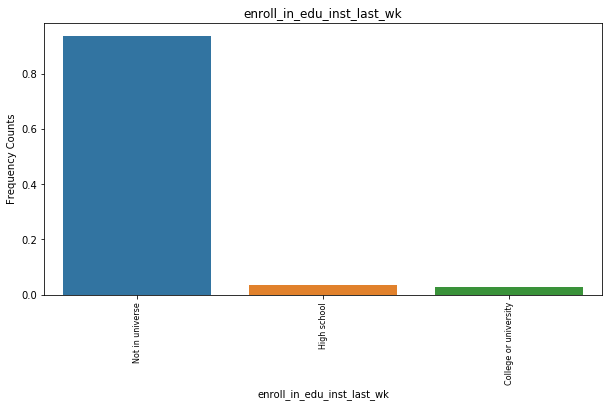

---------------------------
-------marital_stat----------
Never married                      0.433717
Married-civilian spouse present    0.421630
Divorced                           0.064170
Widowed                            0.052676
Separated                          0.017003
Married-spouse absent              0.007451
Married-A F spouse present         0.003354
Name: marital_stat, dtype: float64


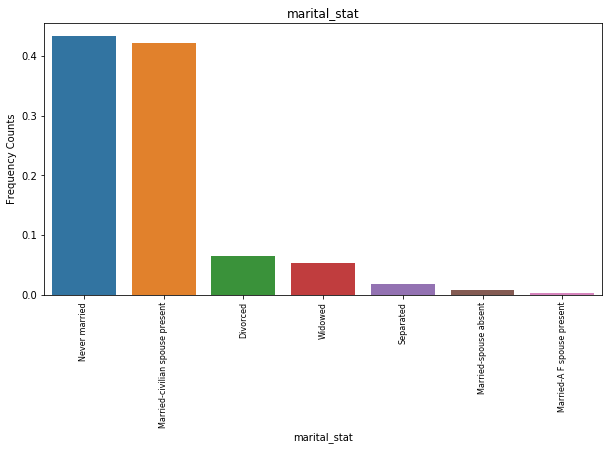

---------------------------
-------major_industry_code----------
Not in universe or children            0.504327
Retail trade                           0.085809
Manufacturing-durable goods            0.045108
Education                              0.041741
Manufacturing-nondurable goods         0.034541
Finance insurance and real estate      0.030623
Construction                           0.030368
Business and repair services           0.028865
Medical except hospital                0.023356
Public administration                  0.022587
Other professional services            0.022437
Transportation                         0.021618
Hospital services                      0.019551
Wholesale trade                        0.017968
Agriculture                            0.014998
Personal services except private HH    0.014635
Social services                        0.012689
Entertainment                          0.008253
Communications                         0.005835
Utilities and sanitary 

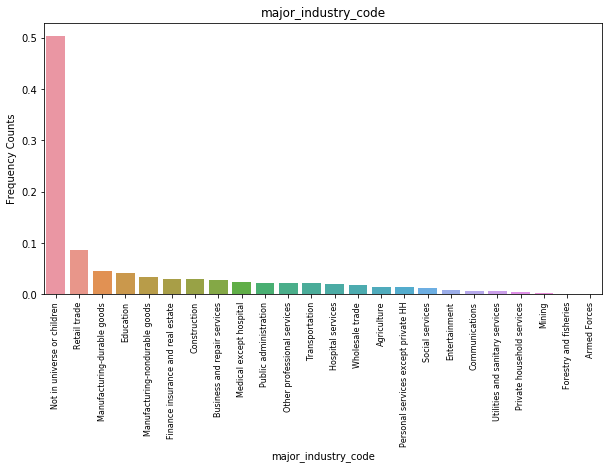

---------------------------
-------major_occupation_code----------
Not in universe                          0.504327
Adm support including clerical           0.073554
Professional specialty                   0.069407
Executive admin and managerial           0.062795
Other service                            0.061037
Sales                                    0.059960
Precision production craft & repair      0.052893
Machine operators assmblrs & inspctrs    0.032035
Handlers equip cleaners etc              0.020495
Transportation and material moving       0.020428
Farming forestry and fishing             0.015687
Technicians and related support          0.015048
Protective services                      0.008073
Private household services               0.004089
Armed Forces                             0.000171
Name: major_occupation_code, dtype: float64


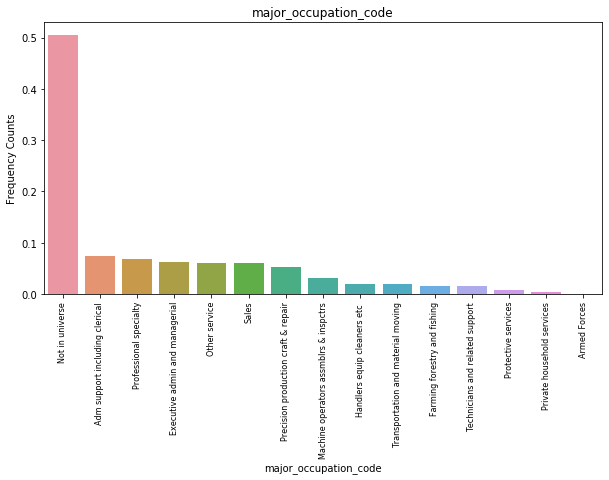

---------------------------
-------race----------
White                          0.839271
Black                          0.101663
Asian or Pacific Islander      0.029090
Other                          0.018498
Amer Indian Aleut or Eskimo    0.011477
Name: race, dtype: float64


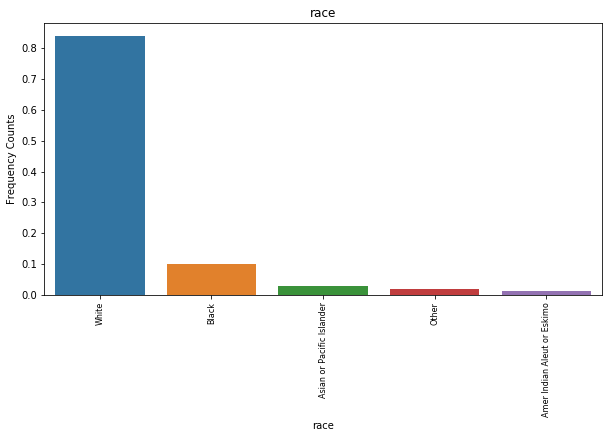

---------------------------
-------hispanic_origin----------
All other                    0.861516
Mexican-American             0.040267
Mexican (Mexicano)           0.036671
Central or South American    0.019593
Puerto Rican                 0.016506
Other Spanish                0.012279
Cuban                        0.005789
-1                           0.004252
Chicano                      0.001646
Do not know                  0.001483
Name: hispanic_origin, dtype: float64


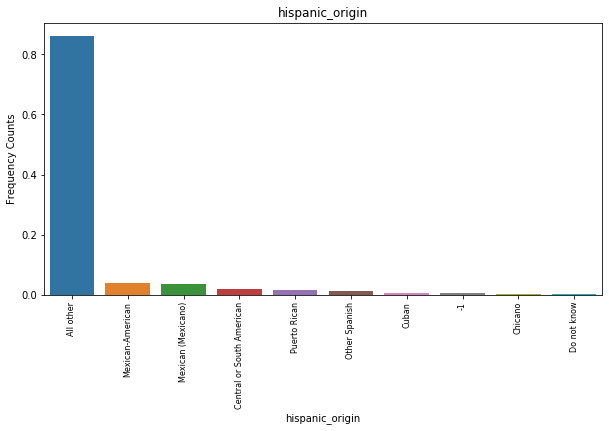

---------------------------
-------sex----------
Female    0.520169
Male      0.479831
Name: sex, dtype: float64


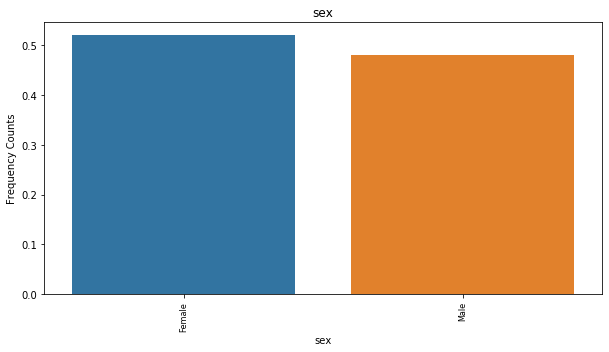

---------------------------
-------member_of_a_labor_union----------
Not in universe    0.904167
No                 0.080767
Yes                0.015065
Name: member_of_a_labor_union, dtype: float64


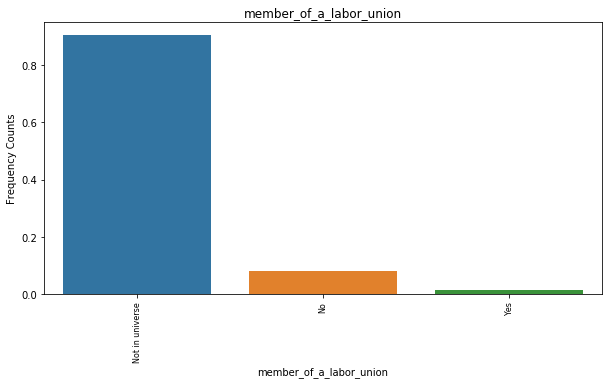

---------------------------
-------reason_for_unemployment----------
Not in universe          0.969390
Other job loser          0.010492
Re-entrant               0.010141
Job loser - on layoff    0.004945
Job leaver               0.002945
New entrant              0.002088
Name: reason_for_unemployment, dtype: float64


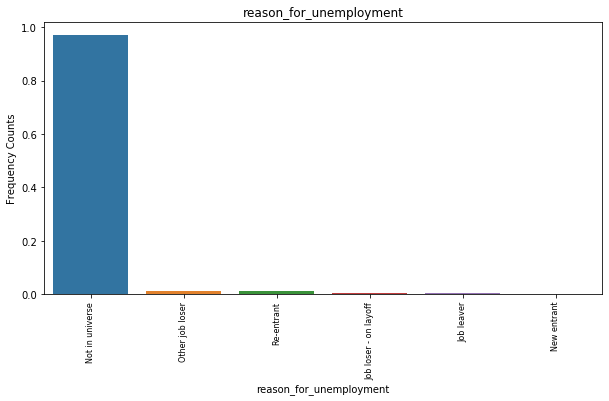

---------------------------
-------full_or_part_time_employment_stat----------
Children or Armed Forces              0.619510
Full-time schedules                   0.205034
Not in labor force                    0.134291
PT for non-econ reasons usually FT    0.016857
Unemployed full-time                  0.011573
PT for econ reasons usually PT        0.005952
Unemployed part- time                 0.004143
PT for econ reasons usually FT        0.002640
Name: full_or_part_time_employment_stat, dtype: float64


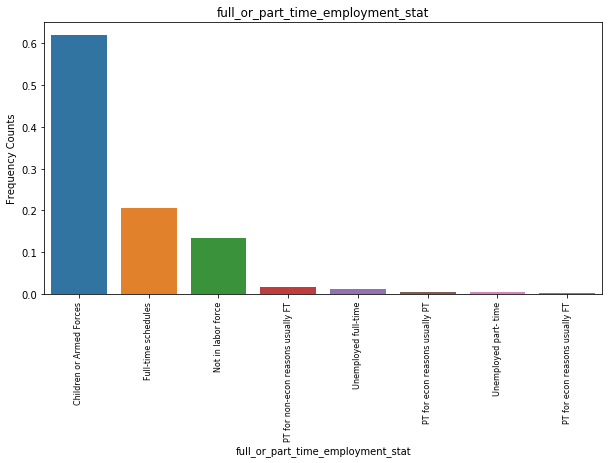

---------------------------
-------tax_filer_stat----------
Nonfiler                        0.375833
Joint both under 65             0.336941
Single                          0.188637
Joint both 65+                  0.041679
Head of household               0.037222
Joint one under 65 & one 65+    0.019689
Name: tax_filer_stat, dtype: float64


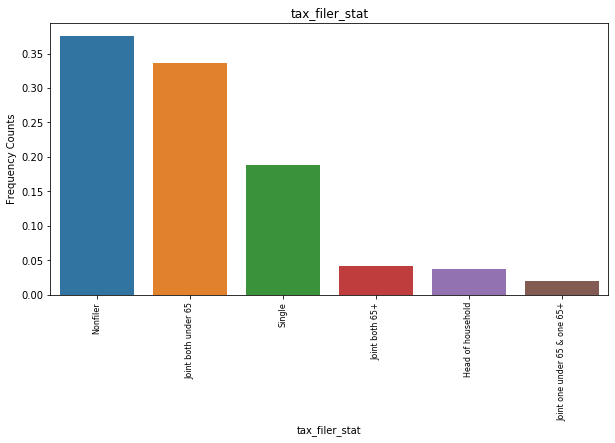

---------------------------
-------region_of_previous_residence----------
Not in universe    0.922119
South              0.024116
West               0.020236
Midwest            0.017609
Northeast          0.013499
Abroad             0.002422
Name: region_of_previous_residence, dtype: float64


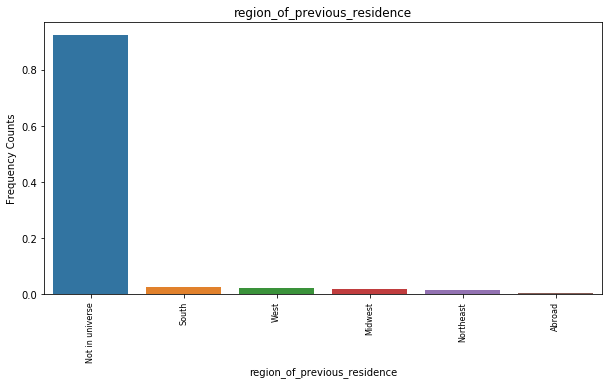

---------------------------
-------state_of_previous_residence----------
Not in universe         0.922119
California              0.008516
Utah                    0.005212
Florida                 0.004277
North Carolina          0.004068
?                       0.003379
Oklahoma                0.003116
Abroad                  0.003107
Indiana                 0.002828
Minnesota               0.002807
New Mexico              0.002360
North Dakota            0.002335
Michigan                0.002155
Alaska                  0.001378
Arizona                 0.001257
Kentucky                0.001215
New Hampshire           0.001169
Oregon                  0.001161
Colorado                0.001157
West Virginia           0.001140
Wyoming                 0.001115
Georgia                 0.001107
Montana                 0.001098
Ohio                    0.001065
Pennsylvania            0.001048
Arkansas                0.001044
Alabama                 0.001036
Texas                   0.001015
Lou

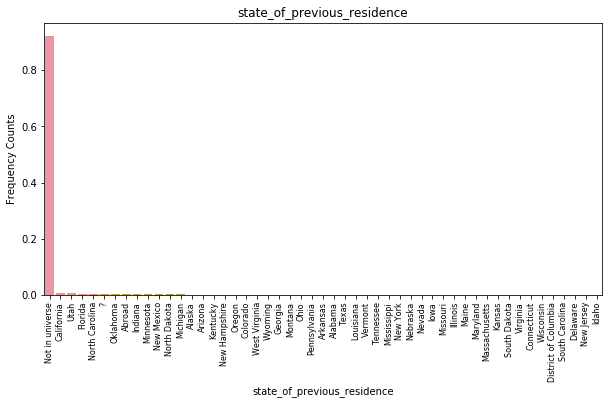

---------------------------
-------detailed_household_and_family_stat----------
Householder                                        0.267567
Child <18 never marr not in subfamily              0.252539
Spouse of householder                              0.207478
Nonfamily householder                              0.111875
Child 18+ never marr Not in a subfamily            0.060749
Secondary individual                               0.031016
Other Rel 18+ ever marr not in subfamily           0.009882
Grandchild <18 never marr child of subfamily RP    0.008996
Other Rel 18+ never marr not in subfamily          0.008524
Grandchild <18 never marr not in subfamily         0.005204
Child 18+ ever marr Not in a subfamily             0.004924
Child under 18 of RP of unrel subfamily            0.003617
Child 18+ ever marr RP of subfamily                0.003383
Other Rel 18+ spouse of subfamily RP               0.003312
RP of unrelated subfamily                          0.003312
Other Rel <18 never 

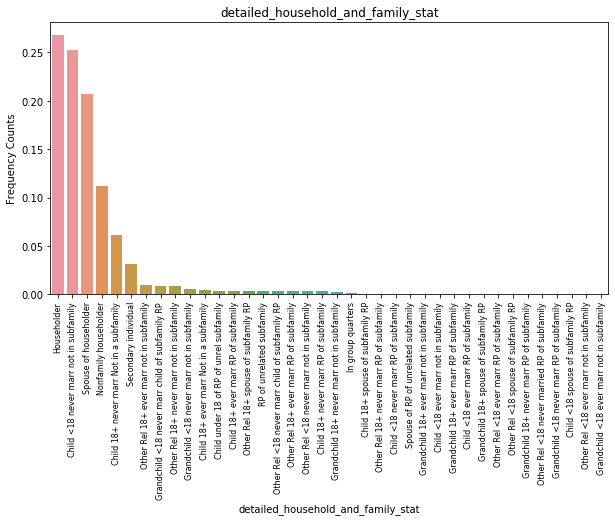

---------------------------
-------detailed_household_summary_in_household----------
Householder                             0.379521
Child under 18 never married            0.253003
Spouse of householder                   0.207540
Child 18 or older                       0.072644
Other relative of householder           0.048181
Nonrelative of householder              0.038258
Group Quarters- Secondary individual    0.000631
Child under 18 ever married             0.000221
Name: detailed_household_summary_in_household, dtype: float64


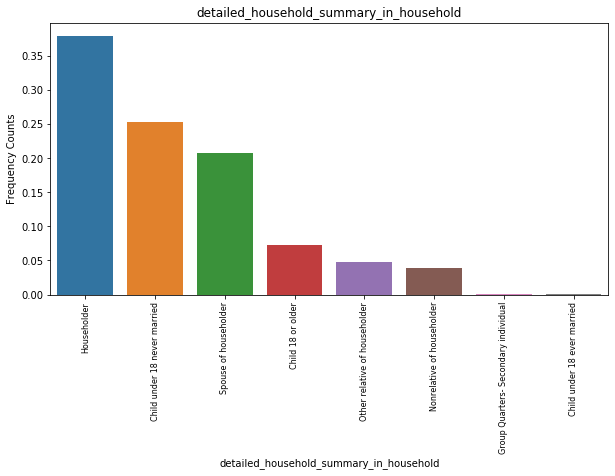

---------------------------
-------migration_code_change_in_msa----------
?                   0.500092
Nonmover            0.414488
MSA to MSA          0.052642
NonMSA to nonMSA    0.013804
Not in universe     0.007539
MSA to nonMSA       0.003922
NonMSA to MSA       0.002990
Not identifiable    0.002122
Abroad to MSA       0.002013
Abroad to nonMSA    0.000388
Name: migration_code_change_in_msa, dtype: float64


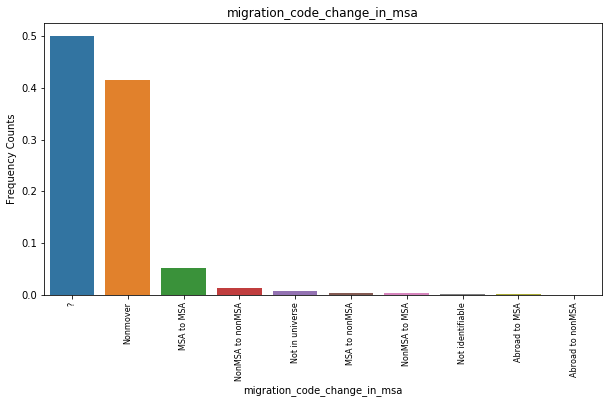

---------------------------
-------migration_code_change_in_reg----------
?                                 0.500092
Nonmover                          0.414488
Same county                       0.048620
Different county same state       0.013729
Not in universe                   0.007539
Different region                  0.005893
Different state same division     0.004941
Abroad                            0.002422
Different division same region    0.002276
Name: migration_code_change_in_reg, dtype: float64


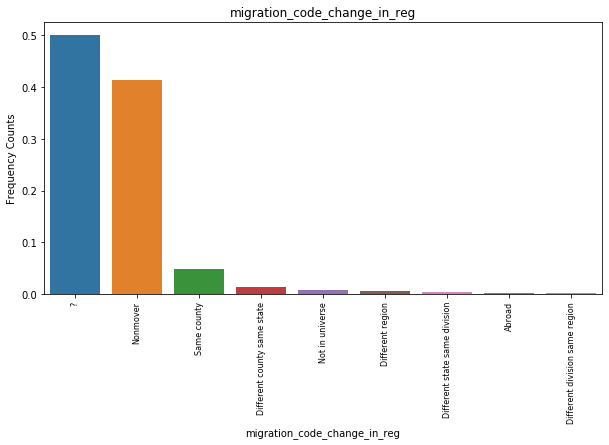

---------------------------
-------migration_code_move_within_reg----------
?                               0.500092
Nonmover                        0.414488
Same county                     0.048620
Different county same state     0.013729
Not in universe                 0.007539
Different state in South        0.004807
Different state in West         0.003475
Different state in Midwest      0.002652
Abroad                          0.002422
Different state in Northeast    0.002176
Name: migration_code_move_within_reg, dtype: float64


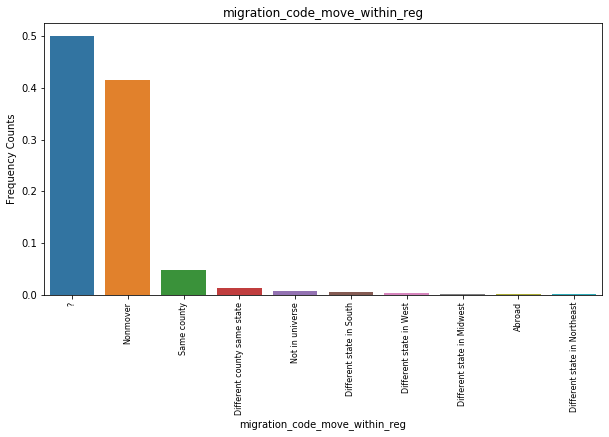

---------------------------
-------live_in_this_house_1_year_ago----------
Not in universe under 1 year old    0.507631
Yes                                 0.414488
No                                  0.077881
Name: live_in_this_house_1_year_ago, dtype: float64


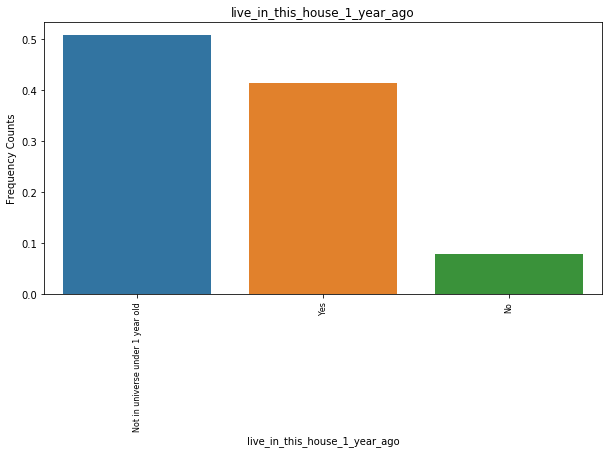

---------------------------
-------migration_prev_res_in_sunbelt----------
?                  0.500092
Not in universe    0.422027
No                 0.049347
Yes                0.028535
Name: migration_prev_res_in_sunbelt, dtype: float64


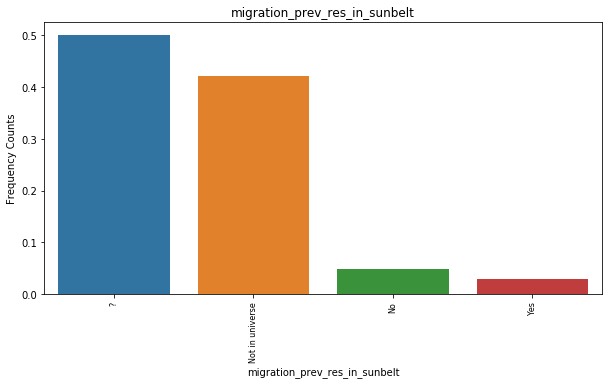

---------------------------
-------family_members_under_18----------
Not in universe           0.723132
Both parents present      0.195984
Mother only present       0.063192
Father only present       0.009443
Neither parent present    0.008249
Name: family_members_under_18, dtype: float64


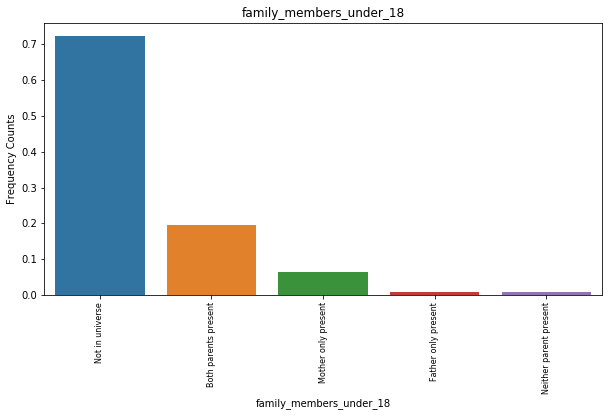

---------------------------
-------country_of_birth_father----------
United-States                   0.796933
Mexico                          0.050562
?                               0.033735
Puerto-Rico                     0.013365
Italy                           0.011177
Canada                          0.006904
Germany                         0.006620
Dominican-Republic              0.006449
Poland                          0.006127
Philippines                     0.005814
Cuba                            0.005760
El-Salvador                     0.004891
China                           0.004089
England                         0.004005
Columbia                        0.002978
India                           0.002899
Ireland                         0.002748
South Korea                     0.002527
Jamaica                         0.002431
Guatemala                       0.002276
Vietnam                         0.002268
Japan                           0.002001
Portugal                     

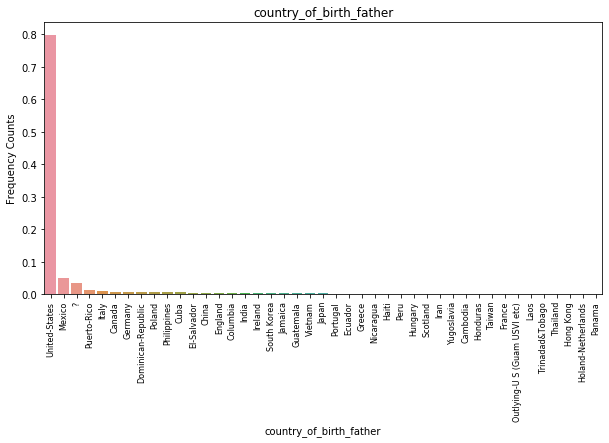

---------------------------
-------country_of_birth_mother----------
United-States                   0.803561
Mexico                          0.049627
?                               0.030807
Puerto-Rico                     0.012367
Italy                           0.009180
Canada                          0.007205
Germany                         0.006837
Philippines                     0.006223
Cuba                            0.005714
Poland                          0.005551
El-Salvador                     0.005371
Dominican-Republic              0.005317
England                         0.004502
China                           0.003680
Ireland                         0.003174
Columbia                        0.002953
South Korea                     0.002940
India                           0.002911
Vietnam                         0.002402
Japan                           0.002397
Jamaica                         0.002376
Guatemala                       0.002260
Ecuador                      

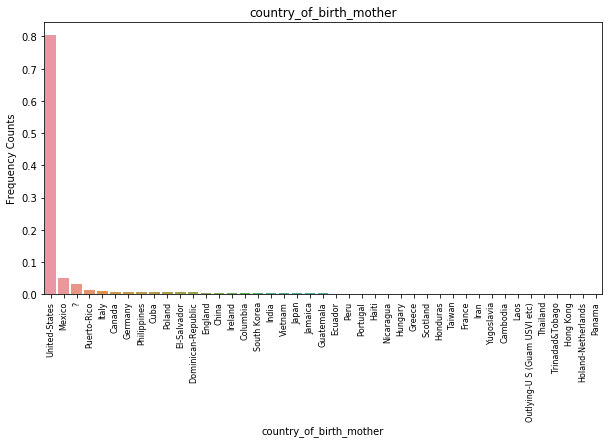

---------------------------
-------country_of_birth_self----------
United-States                   0.886655
Mexico                          0.029220
?                               0.017224
Puerto-Rico                     0.007063
Philippines                     0.004285
Germany                         0.004248
Cuba                            0.004223
Canada                          0.003596
El-Salvador                     0.003379
Dominican-Republic              0.003266
China                           0.002356
South Korea                     0.002297
England                         0.002289
Italy                           0.002155
Columbia                        0.002134
India                           0.002021
Vietnam                         0.001938
Poland                          0.001834
Guatemala                       0.001742
Jamaica                         0.001658
Japan                           0.001654
Ecuador                         0.001332
Peru                           

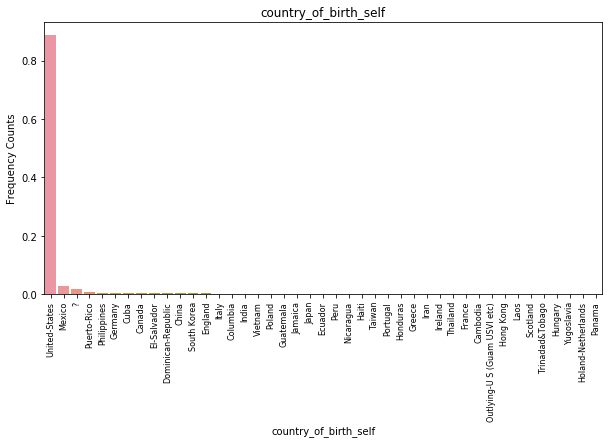

---------------------------
-------citizenship----------
Native- Born in the United States              0.886667
Foreign born- Not a citizen of U S             0.067102
Foreign born- U S citizen by naturalization    0.029629
Native- Born abroad of American Parent(s)      0.009001
Native- Born in Puerto Rico or U S Outlying    0.007601
Name: citizenship, dtype: float64


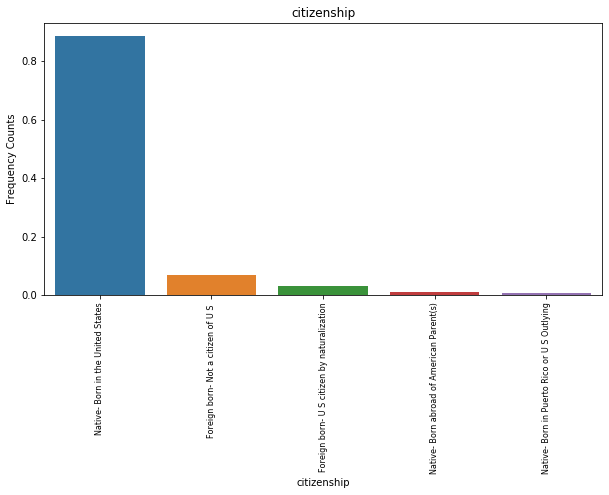

---------------------------
-------own_business_or_self_employed----------
0    0.905358
2    0.081056
1    0.013587
Name: own_business_or_self_employed, dtype: float64


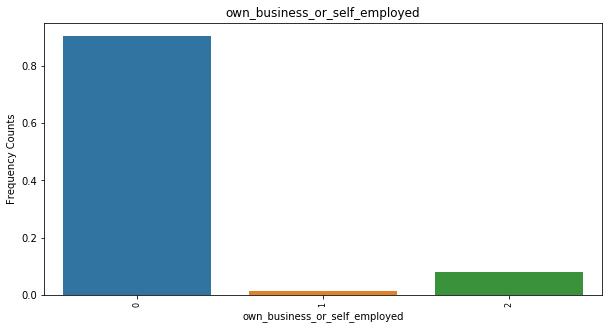

---------------------------
-------fill_inc_questionnaire_for_veteran's_admin----------
Not in universe    0.989859
No                 0.008182
Yes                0.001959
Name: fill_inc_questionnaire_for_veteran's_admin, dtype: float64


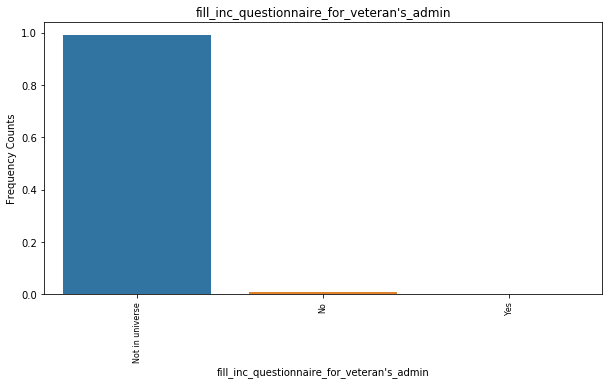

---------------------------
-------veterans_benefits----------
2    0.752527
0    0.237332
1    0.010141
Name: veterans_benefits, dtype: float64


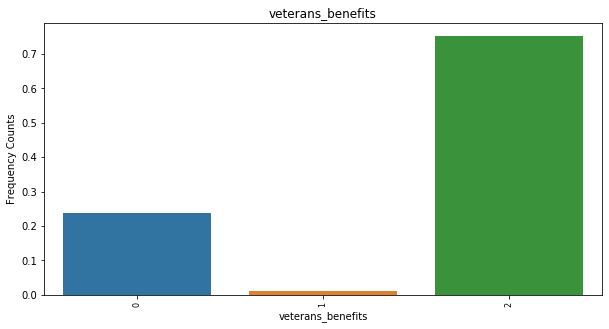

---------------------------


In [24]:
for i, obj_col in enumerate(train_X_obj.columns):
    print(f"-------{obj_col}----------")
    vcounts = train_X_obj[obj_col].value_counts(1)
    print(vcounts)
    categorical_bar_plot(vcounts, vcounts.name)
    print("---------------------------")

### Categorical Variable Selection

**Goal**: Reduce the total categorical feature, select only needed.

Trouble of categorical variables lies in the fact that the most accurate representation
of different categories can be encoded via one-hot encoding but this quickly expands
and demands huge memory consumption.

In [25]:
print(f"All {len(train_X_obj.columns)} categorical columns: {train_X_obj.columns}") 

All 32 categorical columns: Index(['class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'enroll_in_edu_inst_last_wk',
       'marital_stat', 'major_industry_code', 'major_occupation_code', 'race',
       'hispanic_origin', 'sex', 'member_of_a_labor_union',
       'reason_for_unemployment', 'full_or_part_time_employment_stat',
       'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence', 'detailed_household_and_family_stat',
       'detailed_household_summary_in_household',
       'migration_code_change_in_msa', 'migration_code_change_in_reg',
       'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'family_members_under_18',
       'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed',
       'fill_inc_questionnaire_for_veteran's_admin', 'veterans_benefits'],
      dtype='obje

#### Categorical Correlation

Correlation between categorical variable is hard to measure. It is normally done by first transforming
categorical variables into a frequency table more commonly named as contingency table. Then a test can be 
applied to the categorical features to test if there lies significance between the co-occurence of features.

Null Hypothesis: there is no correlation between the selected two categorical features.

Generated p-value can be used as the reference either:
    
1) if it is smaller than 0.05 (commonly accepted as the confidence threshold), we reject the null hypothesis

2) if it is larger than 0.05, we cannot reject the null hypothesis

Code blocks below are for demonstration purpose and did not used in this test.

In [26]:
contingency_table = pd.crosstab(train_X["race"], 
                                train_X["hispanic_origin"])

In [27]:
contingency_table

hispanic_origin,-1,All other,Central or South American,Chicano,Cuban,Do not know,Mexican (Mexicano),Mexican-American,Other Spanish,Puerto Rican
race,,,,,,,,,,
Amer Indian Aleut or Eskimo,16,2510,6,5,2,1,73,99,33,3
Asian or Pacific Islander,21,6815,37,0,0,0,14,8,53,17
Black,109,23601,257,0,43,3,15,10,129,174
Other,18,886,539,50,34,2,1130,719,343,708
White,854,172459,3852,339,1307,349,7548,8805,2382,3050


In [28]:
scipy.stats.kruskal(*contingency_table.values.T)

KruskalResult(statistic=19.236496420506416, pvalue=0.023255443835340853)

### Ways to reduce categorical dimension

This section explores some ways to reduce categorical dimensions:

1. Remove overlapping features by observation

2. Reduce classes into general classes within categorical features

3. Remove redundant categorical variables (those with high amount of nulls)

4. Generate boolean feature that is very low dimensional but still preserves some info

TO-DO (Possible work if longer time allowed):
    
5. One hot encoding with majority preservation - group minority classes as one

6. Target Encoding

#### a. Overlapped feature removal

We can remove some categorical features that are overlapped with others.

1. ['major_industry_code', 'detailed_industry_recode']
2. ['major_occupation_code', 'detailed_occupation_recode']

While both 'detailed_*' features gives more detailed information than the 'major_*' 
versions, the fact that no string labels are provided for understanding the actual 
representation leads me to pick 'major_*' instead as it is easier to determine which
industry does make a difference.

For categorical variables with highly unbalanced distribution but high dimensions such
as these features, the easiest way is to group the minority categories into a single
category. This will therefore become a boolean feature.

3. ['region_of_previous_residence', 'state_of_previous_residence']
4. ['detailed_household_summary_in_household',
    'detailed_household_and_family_stat', 
    'family_members_under_18']
5. ['citizenship',
    'country_of_birth_self']
6. ['education', 'enroll_in_edu_inst_last_wk']
7. ['race', 'hispanic_origin']

Features above has overlapped as well so we choose those all the features located in 
the first position of list because they:
    
1) cover higher range of categories

2) has manageable categories for encoding later

with observations being made in the plots above.

#### b. Category Grouping

1. 'education'

Education mapping is created with domain knowledge about the education system in the
US. Due to the fact that we do not have a direct mapping provided, the respective
classified categories are given after checking the level of education online.

In [29]:
education_mappings = {
    'Children': 'none',
    'Less than 1st grade': 'primary',
    '1st 2nd 3rd or 4th grade': 'primary', 
    '5th or 6th grade': 'primary',
    '7th and 8th grade': 'secondary', 
    '9th grade': 'secondary',
    '10th grade': 'secondary',
    '11th grade': 'secondary',
    '12th grade no diploma': 'secondary',
    'High school graduate': 'secondary',
    'Some college but no degree': 'tertiary',
    'Associates degree-academic program': 'tertiary',
    'Associates degree-occup /vocational': 'tertiary',
    'Bachelors degree(BA AB BS)': 'tertiary',
    'Masters degree(MA MS MEng MEd MSW MBA)': 'tertiary',
    'Doctorate degree(PhD EdD)': 'tertiary',
    'Prof school degree (MD DDS DVM LLB JD)': 'tertiary'
}

In [30]:
# train_X['education'] = train_X['education'].replace(education_mappings)

2. 'full_or_part_time_employment_stat'

In [31]:
employment_mappings = {
    'Not in labor force': 'nw',
    'Children or Armed Forces': 'nw',
    'Unemployed full-time': 'nw',
    'Unemployed part- time': 'nw',
    'PT for non-econ reasons usually FT': 'pt',
    'PT for econ reasons usually PT': 'pt',
    'PT for econ reasons usually FT': 'pt',
    'Full-time schedules': 'ft'
}

In [32]:
# train_X['full_or_part_time_employment_stat'] =\
# train_X['full_or_part_time_employment_stat'].replace(employment_mappings)

#### c. Category Redundacy Removal

1. 'reason_for_unemployment'
2. ['migration_code_change_in_msa', 
    'migration_code_change_in_reg', 
    'migration_code_move_within_reg',
    'migration_prev_res_in_sunbelt']
3. 'fill_inc_questionnaire_for_veteran's_admin'

Features above were discarded because:

1. Extremely disproportionate distribution of feature

2. Presence of high amount of '?' (unknown) category within

3. Filled questionnaire can be biased as the outcome of filled questionnaire might not
necessarily be of a deterministic set of reasons

#### d. Boolean Generation

Given some features that seem to be very similar and do have connections based on 
observation, we could possibly shrink the dimension of the features by combining them.

The easiest way is to create a boolean feature that encodes the similarity / difference
between multiple feature columns.

We can also perform the same operation on columns with highly skewed sitribution, i.e converting the column
into majority vs non-majority.

1. ['country_of_birth_father',
    'country_of_birth_mother'
    ]

In [33]:
# train_X['parents_country_bool'] = \
# train_X['country_of_birth_father'] == train_X['country_of_birth_mother']

2. ['major_industry_code']

In [34]:
# train_X['major_industry_code'] = \
# df['major_industry_code'] == df['major_industry_code'].value_counts().idxmax()

### Final Selection (Categorical Variable)

In [35]:
categorical_feats = \
['class_of_worker',
 'marital_stat',
 'sex',
 'member_of_a_labor_union',
 'tax_filer_stat',
 'veterans_benefits',
 # Filtered overlapped
 'major_industry_code', 
 'major_occupation_code',
 #'region_of_previous_residence',
 'live_in_this_house_1_year_ago',
 'detailed_household_summary_in_household',
 'citizenship',
 'education',
 'race',
 'full_or_part_time_employment_stat'
 # Generated Feature
 #'parents_country_bool'
]

In [36]:
for categorical_feat in categorical_feats:
    print(f"{categorical_feat} - {len(train_X[categorical_feat].unique())}")

class_of_worker - 9
marital_stat - 7
sex - 2
member_of_a_labor_union - 3
tax_filer_stat - 6
veterans_benefits - 3
major_industry_code - 24
major_occupation_code - 15
live_in_this_house_1_year_ago - 3
detailed_household_summary_in_household - 8
citizenship - 5
education - 17
race - 5
full_or_part_time_employment_stat - 8


# Feature Selection

In [37]:
all_feats = categorical_feats + numerical_feats

# Preprocessor

Build a preprocessor class so we can use it as a transformer as part of our pipeline. 

Integrating into the pipeline allows anyone to directly feed in the input data without issues on any preprocessing steps.

In [38]:
class Preprocessor:
    def __init__(self, all_feats=None):
        # Store the mappings within preprocessor class
        self._education_mappings = {
            'Children': 'none',
            'Less than 1st grade': 'primary',
            '1st 2nd 3rd or 4th grade': 'primary', 
            '5th or 6th grade': 'primary',
            '7th and 8th grade': 'secondary', 
            '9th grade': 'secondary',
            '10th grade': 'secondary',
            '11th grade': 'secondary',
            '12th grade no diploma': 'secondary',
            'High school graduate': 'secondary',
            'Some college but no degree': 'tertiary',
            'Associates degree-academic program': 'tertiary',
            'Associates degree-occup /vocational': 'tertiary',
            'Bachelors degree(BA AB BS)': 'tertiary',
            'Masters degree(MA MS MEng MEd MSW MBA)': 'tertiary',
            'Doctorate degree(PhD EdD)': 'tertiary',
            'Prof school degree (MD DDS DVM LLB JD)': 'tertiary'
        }
        
        self._employment_mappings = {
            'Not in labor force': 'nw',
            'Children or Armed Forces': 'nw',
            'Unemployed full-time': 'nw',
            'Unemployed part- time': 'nw',
            'PT for non-econ reasons usually FT': 'pt',
            'PT for econ reasons usually PT': 'pt',
            'PT for econ reasons usually FT': 'pt',
            'Full-time schedules': 'ft'
        }
        
        self._all_feats = all_feats
        
    def preprocess(self, df, all_feats=None):
        if not self._all_feats:
            self._all_feats = all_feats
        
        # Enforce these features to categorical as they are meant to be
        int_to_str_cols = ['detailed_industry_recode', 
                           'detailed_occupation_recode',
                           'own_business_or_self_employed',
                           'veterans_benefits']

        df[int_to_str_cols] = df[int_to_str_cols].astype(str)
        
        # Apply mappings if such columns exist
        if 'education' in df:
            df['education'] = df['education'].replace(self._education_mappings)
            
        if 'full_or_part_time_employment_stat' in df:
            df['full_or_part_time_employment_stat'] = \
            df['full_or_part_time_employment_stat'].replace(employment_mappings)
            
        # Generate boolean variables
        df['parents_country_bool'] = \
        df['country_of_birth_father'] == df['country_of_birth_mother']
        
        df['major_industry_code'] = \
        df['major_industry_code'] == df['major_industry_code'].value_counts().idxmax()
            
        # Only filter needed features
        if self._all_feats:
            df = df[self._all_feats]

        return df

In [39]:
#preprocessor = Preprocessor(all_feats)

# Oversampling and Undersampling

Given the imbalanced distribution, sometimes the model may has difficulty in recognising
the pattern of the minority class. We have two general solutions:
    
1. Oversampling

We repeatedly re-sample and thus duplicate the minority class to allow model pick up
patterns.

2. Undersampling

We reduce the majority class so the model can fit lesser towards the majority class
pattern.

In this test, I double the minority class population to alleviate disproportionate ratio of population.

In [40]:
stored_trainX_names = train_X.columns.tolist()

In [41]:
ros = RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy=0.12)
train_X, train_y = ros.fit_resample(train_X, train_y)

In [42]:
train_X = pd.DataFrame(train_X)\
            .rename(columns={i: val for i, val in enumerate(stored_trainX_names)})

for col in stored_trainX_names:
    train_X[col] = train_X[col].astype(test_X[col].dtype)

train_y = pd.Series(train_y).rename(test_y.name)

# Transformer Construction

In [43]:
class PreprocessTransformer(TransformerMixin):
    
    def __init__(self, all_feats):
        self._preprocessor = Preprocessor(all_feats)
        
    def transform(self, input_df):
        return self._preprocessor.preprocess(input_df)
    
    def fit(self, *_):
        return self

DummyCodingTransformer is mainly used to convert categorical features into one-hot encoding format.

It also has the benefits of capturing cases where new classes present within categorical features in the test
data. In this case, we set any new classes to zero.

In [44]:
class DummyCodingTransformer(TransformerMixin):
    
    def __init__(self, feature_list=None, default_column_names=None):
        self.feature_list = feature_list
        self.dummy_columns = None
        self.all_columns = None
        self.default_column_names = default_column_names

    def transform(self, input_df, **transform_params):
        
        # Check if the input is dataframe
        if not isinstance(input_df, pd.DataFrame):
            input_df = pd.DataFrame(input_df, columns=self.default_column_names)

        if self.feature_list is not None:
            feat_list = self.feature_list
        else:
            feat_list = input_df.columns

        dummy_cols = []
        # Apply dummy coding for all features in feature list
        for col in feat_list:
            # Get the dummy coding
            dummies_df = pd.get_dummies(input_df[col], prefix=col)

            # Drop original feature from dataset
            input_df = input_df[input_df.columns[~input_df.columns.isin([col])]]

            # Add dummy codding instead of original feature
            input_df = pd.concat([input_df, dummies_df], axis=1)

            # Keep track of dummy columns in train set
            dummy_cols.extend(dummies_df.columns)

        # Check if test dataset has the same number of columns as train
        missing_columns = set(self.dummy_columns) - set(dummy_cols)
        
        for missed_col in missing_columns:
            input_df[missed_col] = 0

        # Check the order of columns are the same
        input_df = input_df[list(self.all_columns) + list(self.dummy_columns)]
        return input_df

    def fit(self, input_df, *_):
        
        # Check if the input is dataframe
        if not isinstance(input_df, pd.DataFrame):
            input_df = pd.DataFrame(input_df, columns=self.default_column_names)

        if self.feature_list is not None:
            feat_list = self.feature_list
        else:
            feat_list = input_df.columns

        dummy_cols = []
        
        # Apply dummy coding for all features in feature list
        for col in feat_list:
            # Get the dummy coding
            dummies_df = pd.get_dummies(input_df[col], prefix=col)

            # Drop original feature from dataset
            input_df = input_df.drop(columns=[col])

            # Keep track of dummy columns in train set
            dummy_cols.extend(dummies_df.columns)

        self.dummy_columns = dummy_cols
        self.all_columns = input_df.columns

        return self

    def get_feature_list(self):
        return list(self.all_columns) + list(self.dummy_columns)

FeatureExtractorTransformer only collects feature columns with no any processing done, mainly used for ensuring
features get picked.

In [45]:
class FeatureExtractorTransformer(TransformerMixin):

    def __init__(self, feature_list):
        self.feature_list = feature_list

    def transform(self, input_df, **transform_params):
        # return selected features from dataframe
        return input_df[self.feature_list]

    def fit(self, *_):
        return self

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"feature_list": self.feature_list}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Pipeline Building

We combine the transformers with parameters we would like to perform grid search into pipelines. This eases the
process to train the model and also for prediction.

In [46]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [47]:
# Logistic Regression
pipe_lr = Pipeline([
                    ('preprocessor', Pipeline([
                                   ('preprocess', PreprocessTransformer(all_feats))
                    ])),
                    ('features', FeatureUnion([
                               ('categorical', Pipeline([
                                   ('extract', FeatureExtractorTransformer(categorical_feats)),
                                   ('dummy_coding', DummyCodingTransformer())
                               ])),
                               ('numerical', Pipeline([
                                    ('extract', FeatureExtractorTransformer(numerical_feats))
                                ])),     
                    ])), 
                    ('clf', LogisticRegression())
                   ])

# XGBoost
pipe_xgb = Pipeline([
                    ('preprocessor', Pipeline([
                                   ('preprocess', PreprocessTransformer(all_feats))
                    ])),
                    ('features', FeatureUnion([
                               ('categorical', Pipeline([
                                   ('extract', FeatureExtractorTransformer(categorical_feats)),
                                   ('dummy_coding', DummyCodingTransformer())
                               ])),
                               ('numerical', Pipeline([
                                    ('extract', FeatureExtractorTransformer(numerical_feats))
                                ])),     
                    ])),   
                     ('clf', XGBClassifier())
                    ])

In [48]:
# Logistic Regression
grid_params_lr = {'clf__penalty': ['l1', 'l2']}

# XGBoost
grid_params_xgb = {
                   'clf__n_estimators': np.arange(100, 300, 100), # number of trees in the foreset 
                   'clf__learning_rate': [0.1],
                   'clf__max_depth':np.arange(2,11,3), # max number of levels in each decision tree 
                  } 

In [49]:
# Logistic Regresssion
logistic_pipe = {'name': 'Logit',
                 'model': pipe_lr,
                 'params': grid_params_lr}

# XGBoost
xgboost_pipe = {'name': 'XGBoost',
                'model': pipe_xgb,
                'params': grid_params_xgb}

In [50]:
# Comment out any pipe if you do not want to run the model
list_of_pipelines = [logistic_pipe,
                    xgboost_pipe
                    ]

# Model Training

We perform stratified K fold as there might be insufficient minority class within the fold during training.

In [51]:
# Number of Procssors (Only 4 CPUs on my laptop but could be adjusted accordingly)
NUMBER_OF_PROCESSORS = 4

# Cross Validation
K_FOLD = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE)

# Scoring
SCORING = 'recall'

# Hyper Parametes Iteration
n_hyper_params_iter = 100

# Cross Validation Parameters
n_outer_fold = 5
n_inner_fold = 2

An object to store all performance related metrics.

In [52]:
class ModelPerformance:
    def __init__(self, model, model_name):
        self._model = model
        self._model_name = model_name
        self._perf = dict()
        self._calibs = dict()
        self._prob = dict()
        
    @property
    def perf(self):
        return self._perf
    
    @perf.setter
    def perf(self, val):
        self._perf = val
        
    @property
    def calibs(self):
        return self._calibs
    
    @calibs.setter
    def calibs(self, val):
        self._calibs = val
        
    @property
    def prob(self):
        return self._prob
    
    @prob.setter
    def prob(self, val):
        self._prob = val    

In [53]:
trained_models = dict()

In [54]:
for index, pipe in enumerate(list_of_pipelines):
    # Measure time spent on training each model
    model_train_start = time.time()
    
    # Stratified K Fold validation as to maintain the imbalanced data 
    # distribution within folds
    k_fold = StratifiedKFold(n_splits=n_inner_fold, random_state=RANDOM_STATE)
    
    
    # Perform GridSearch Cross Validation    
    model = GridSearchCV(estimator=pipe['model'], 
                         param_grid=pipe['params'], 
                         scoring=SCORING, 
                         cv=k_fold, 
                         n_jobs=NUMBER_OF_PROCESSORS)
    
    # Train the model
    model.fit(train_X, train_y)
    
    trained_models[pipe['name']] = ModelPerformance(model, pipe['name'])
    
    gc.collect()
    
    model_train_end = time.time()
    
    print(f"Model training for {pipe['name']} took\
          {model_train_end-model_train_start:.5} seconds.")

/home/hoechenw/development/wrm/wr_ml_exercise_2019/wrm_venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model training for Logit took          62.291 seconds.
Model training for XGBoost took          524.71 seconds.


In [55]:
class ModelWrapper:
    def __init__(self, 
                 model, 
                 model_name,
                 evaluation_threshold = 0.5):
        self._model = model
        self._model_name = model_name
        self._evaluation_threshold = evaluation_threshold
        
    def predict_proba(self, input_rows):
        return self._model.predict_proba(input_rows)[:,1]
    
    def predict_label(self, input_rows):
        pred_labels = self._model.predict_proba(input_rows)[:,1] >= self._evaluation_threshold
        pred_labels = ['>50k' if pred_label else '<=50k' for pred_label in pred_labels]
        return pred_labels

In [56]:
for model_name, model_perf in trained_models.items():
    cur_model = ModelWrapper(model_perf._model, model_name)
    pickle.dump(cur_model, open(f"./models/{model_name}.pkl", "wb"))

# Evaluation

For evaluation within the context of this analysis, we are highly interested in:
    
1) Precision
Ability of model to correctly classifies between people earning '<=50k' and 
people earning '>50k' 

2) Recall
Ability of model to correctly identifies people earning '>50k' as we label '>50k' as 1
the positive class, also the minority class in this dataset

3) F1 Score
Balance between precision and recall of the model

Accuracy is inserted as well for reference. In such unbalanced dataset, accuracy is not
reliable. This is because most of the successfully predicted labels may come from the
majority class while the model fails to predict any minority class.

In [57]:
# performance evaluation function
def eval_performance(true_y: np.array, 
                     pred_y_prob: np.array, 
                     cutoff_Threshold: int = 0.5) -> dict:
    # predict validation set - class
    y_pred_class = np.where(pred_y_prob > cutoff_Threshold,1 ,0)

    # F-Score
    fscore = f1_score(true_y, y_pred_class)  
    
    # Precision
    precision = precision_score(true_y, y_pred_class)  
    
    # Recall
    recall = recall_score(true_y, y_pred_class) 
    
    # Accuracy
    accuracy = accuracy_score(true_y, y_pred_class)  

    result = {'f1': fscore, 
              'precision': precision, 
              'recall': recall, 
              'accuracy':accuracy}
    
    return result

## Model Performance Object Storage

In [58]:
def gen_evaluation(model_perf: ModelPerformance,
                   test_y: np.array, 
                   pred_y_prob: np.array, 
                   EVALUATION_THRESHOLD: int) -> ModelPerformance:
    
    # Evaluate the model        
    model_perf.perf = eval_performance(test_y, pred_y_prob, EVALUATION_THRESHOLD)
    
    # Extract data for calibration graph
    fraction_of_positives, mean_predicted_value = calibration_curve(test_y, pred_y_prob, n_bins=20)

    # Extract data for calibration plot
    model_perf.calibs = {'frac_pos':fraction_of_positives, 'mean_predicted':mean_predicted_value}
    
    # Store predicted_y probability
    model_perf.prob = pred_y_prob
    
    return model_perf

In [59]:
prediction_perf = dict()

for model_name, model_perf in trained_models.items():
    pred_y_prob = model_perf._model.predict_proba(test_X)[:,1]
    prediction_perf[model_name] = gen_evaluation(model_perf, test_y, pred_y_prob, 0.5)

# Visualisation and Comments

Performance of both XGBoost and Logistic Regression are similar with XGBoost slightly better than Logistic Regression.

However, training speed of Logistic Regression is significantly faster so depending on the use case, we might 
want to consider that as part of the model selection criteria. 

System with the need for regular training due to ever-changing pattern such as fraud will have to take into 
account of training speed and the ability to handle high dimensional features.

If getting as many positive class as correct is our main focus, we can maximise recall at the expense of 
reducing precision. Predicting by probability rather than a strict label allows us to make decision 
accordingly based on the precision-recall trade off. 

If we are aiming to maximise the model's ability to correctly distinguish between positive and negative classes,
we can increase precision at the expense of reducing recall.

If not, using the F1 score as the decision metric is valid as well.

### Mini Conclusion

I will prefer Logistic Regression in this case due to the fact that the performance of it closely matches the 
other model but trains much faster.

XGBoost fits better in data where pattern is more obscure and we can take advantage of the fact that it has
in-built feature importance library to filter out non-significant features.

In [60]:
df_prediction_perf = pd.DataFrame({model_name: model_perf.perf
                                  for model_name, model_perf in prediction_perf.items()})

In [61]:
df_prediction_perf

,Logit,XGBoost
f1,0.517986,0.584991
precision,0.583247,0.646138
recall,0.465859,0.534416
accuracy,0.947391,0.953990


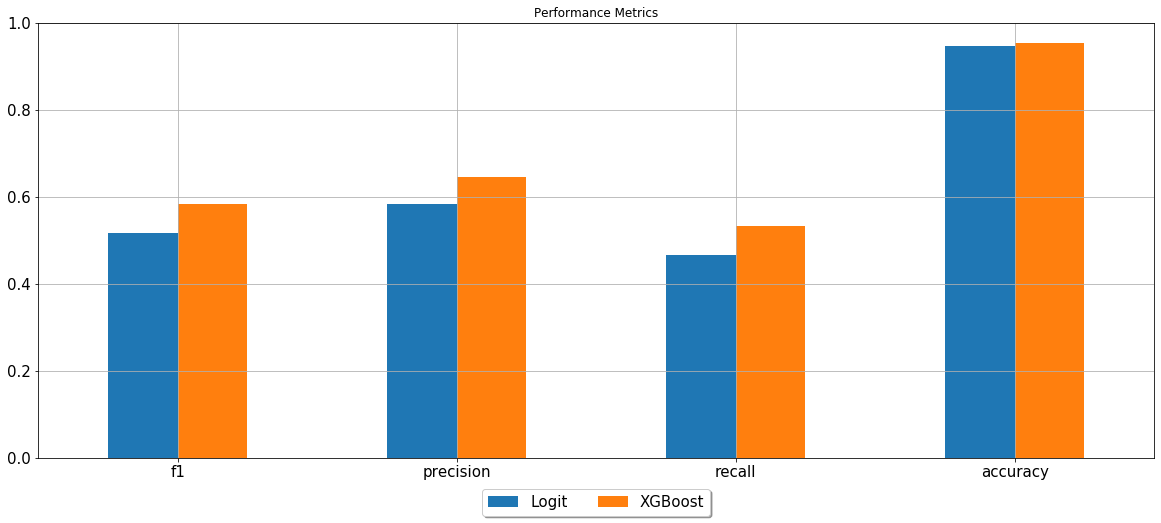

In [62]:
f, ax = plt.subplots(figsize=(20,8))
df_prediction_perf.plot.bar(ax=ax)
ax.set_ylim(0,1)
ax.set_title('Performance Metrics')

box = ax.get_position()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(df_prediction_perf)-1, fontsize=15, shadow=True)
plt.tick_params(rotation=0, labelsize=15)

# Set grid lines
ax.grid(which='major')

# Evaluation Threshold Selection

A threshold can be set to be the decision point on classifying whether a data point 
belongs to the '<=50k' or '>50k' groups.

Normally this threshold can be selected by:
    
1. Divide the train data into further subsidiary train and subsidiary test dataset at 80-20.

2. Cross-validation style training on the subsidiary train data and test it on subsidiary test data.

3. If the results (precision and recall and f1-score) are satisfactory, plot the calibration curve.

4. Plotted line running along the diagonal of calibration plot is the perfectly calibrated line, pick the point
of trained model closest to the perfectly calibrated plotted line as the evaluation threshold.

Note that doing the above is beneficial to the fact that we can observe whether there is a shift in the
trained population vs the test population. If performance of model in both:
    
1. subsidiary train to subsidiary test (80-20) of train
2. train to test (80-20) of whole dataset

are similar, then it suggests our model is stable.

### Sample Calibration Plot

Calibration Plot below is an example by using the test resuts. When choose evaluation threshold, DO NOT use
test results, instead use the approach suggested above (retrieve from subsidiary train and test).

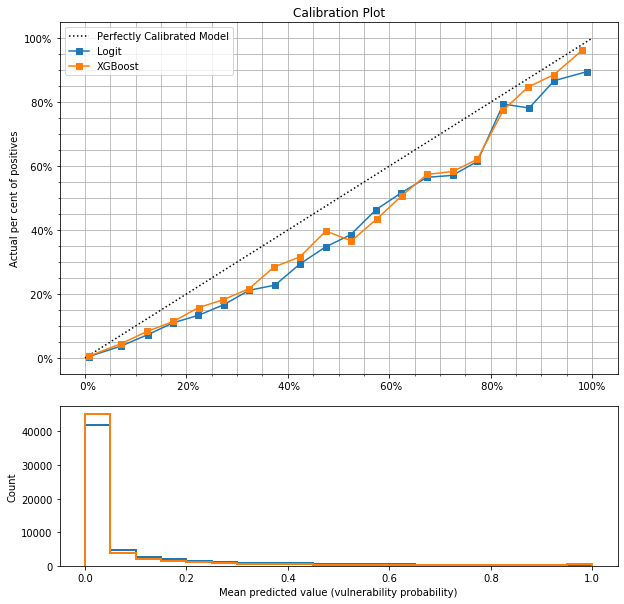

In [63]:
# Create a figure to display calibration plot
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
ax2 = plt.subplot2grid((3,1), (2,0))

# Plot a diagonal line to simulate perfectly calibrated plot
ax1.plot([0,1],[0,1], 'k:', label='Perfectly Calibrated Model')
    
# Set axis label
ax1.set_ylabel("Actual per cent of positives")

# Set grid lines
ax1.minorticks_on()
ax1.grid(which='major')
ax1.grid(which='minor')

# Format axis as percentage
vals_x = ax1.get_xticks()
ax1.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals_x])
vals_y = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals_y])

# Set axis setting
ax2.set_xlabel("Mean predicted value (vulnerability probability)")
ax2.set_ylabel("Count")

# Set title
ax1.set_title('Calibration Plot')

# Generate calibration plots
for i, (model_name, model_perf) in enumerate(prediction_perf.items()):

    # Plot calibration line
    ax1.plot(model_perf.calibs['mean_predicted'], 
         model_perf.calibs['frac_pos'], 
         's-', 
         label=model_name)
    
    # Plot histogram of probability
    ax2.hist(model_perf.prob, range=(0,1), bins=20,histtype="step", lw=2)
        
    # Add legend
    ax1.legend(loc="upper left", fontsize=10)